# Phylogenetic regression using regularized kernels

In this tutorial, we assume you have three pieces of information: the feature matrix X, the response vector y, and the covariance matrix.

### Notes in the data formatting
The rows in the X matrix, y vector, and covariance matrix should be arranged in the same order. The covariance matrix is derived from the phylogeny. In R, the `ape` package can be used to obtain it. For instance, under the assumption of Brownian motion, it can be acquired as follows:

```{r}
library(ape)

my_tree <- ape::read.tree('path/to/tree')
my_cov <- ape::vcv.phylo(my_tree)

# write a matrix
write.table(my_cov, 'cov.csv', 
            row.names = F, 
            col.names = F, 
            sep = ',')
```

## The data

The data used throughout this tutorial is simulated using Equation 5 and b = 4, as outlined in the main text

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# get data
data = np.loadtxt('./data/test_data.csv', delimiter=',')
X,y = data[:,:-1], data[:,-1]

Plotting above data we have:

Text(0.5, 0, 'PC1 of features')

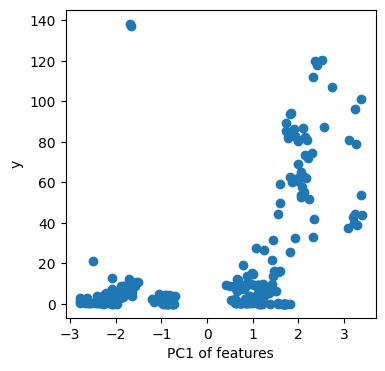

In [10]:

# function to reduce dimenstionality
def dim_red(X, n_com):
    # extracting averages
    X_centered = (X - np.mean(X, axis=0))

    # U,E,Vt (SVD)
    _,_,Vt = np.linalg.svd(X_centered)
    # PCA components
    W = Vt.T[:, :n_com]
    # projection into n_com dimensions
    return X_centered.dot(W)

# PC1 of feautures
X1D = dim_red(X, 1)

plt.rcParams['figure.figsize'] = [4, 4]

plt.scatter(X1D[:,0], y,)
plt.ylabel('y')
plt.xlabel('PC1 of features')


## Adding data into the model class



In [11]:
from phylokrr.core import PhylogeneticRegressor

# get data
data = np.loadtxt('./data/test_data.csv', delimiter=',')
X,y = data[:,:-1], data[:,-1]

# get covariance matrix
cov = np.loadtxt('./data/test_cov.csv',delimiter=',')

# set model
model = PhylogeneticRegressor(X, y, cov, kernel='rbf')

## Set the hyperparamter space and fit

The best set of hyperparamters is obtained with cross-validation rounds using the training set (as default 60% of the rounds)


In [12]:
# broad hyperparamter space
params = {
    'lambda' : np.logspace(-5, 15, 100, dtype = float, base=2),
    'gamma' : np.logspace(-15, 3, 100, dtype = float, base=2),
}

model.set_hyperparamter_space(params=params)

# fit the model
model.fit(seed=12)

CV score:  5.803943880872447
hyperparameters: {'lambda': 0.047565541286280176, 'gamma': 0.07550559027527799}
Training error: 4.485478319237033
Testing error: 4.431854481792635


Alternatively you can also manually set an specific set of hyperparamters and the re-fit:

In [13]:
model.set_params(
    {'lambda': 0.0001, 'gamma': 0.0755},
    fit=True
)

Training error: 1.1970981046583578
Testing error: 1.420436007055721


## Permutation Feature Importance

Text(0, 0.5, 'RMSE increase')

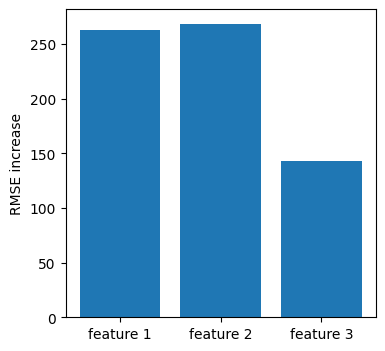

In [14]:
feature_names = ['feature 1', 'feature 2', 'feature 3']

FI = model.FeatureImportance(seed=None)

plt.bar(feature_names, FI)
plt.ylabel('RMSE increase')


## Partial Depedence Plot

Text(0.5, 0, 'feature 3')

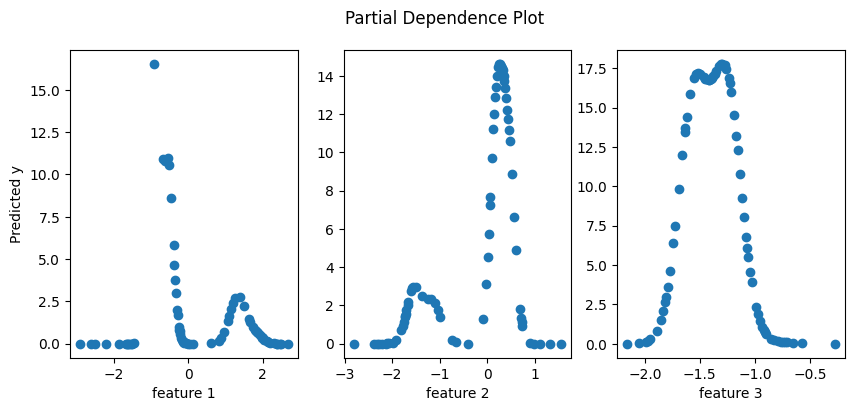

In [15]:

# PDP calculations
pdp_0 = model.pdp(feature=0)
pdp_1 = model.pdp(feature=1)
pdp_2 = model.pdp(feature=2)


# plotting
plt.rcParams['figure.figsize'] = [10, 4]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Partial Dependence Plot')

ax1.scatter(pdp_0[:,0], pdp_0[:,1])
ax1.set_ylabel('Predicted y')
ax1.set_xlabel(feature_names[0])

ax2.scatter(pdp_1[:,0], pdp_1[:,1])
ax2.set_xlabel(feature_names[1])

ax3.scatter(pdp_2[:,0], pdp_2[:,1])
ax3.set_xlabel(feature_names[2])



#